<a href="https://colab.research.google.com/github/ting486/Consumer-Reviews-And-Purchasing-Decisions/blob/main/The_Impact_of_Consumer_Reviews_on_BSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Reviews Data Analysis

## Notebook Setup

In [1]:
# check available RAM
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        553M         21G        1.2M        3.9G         24G
Swap:            0B          0B          0B


In [84]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import re
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download(['vader_lexicon','stopwords'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Initial Data
Data source: http://deepyeti.ucsd.edu/jianmo/amazon/index.html

In [4]:
# get products data
dfProd = pd.read_json('gdrive/MyDrive/amazon_data/meta_Video_Games.json', lines=True)

In [5]:
print(dfProd.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [6]:
# get reviews data
dfReviews = pd.read_json("gdrive/MyDrive/amazon_data/Video_Games.json", lines=True)

In [7]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         2565349 non-null  int64 
 1   verified        2565349 non-null  bool  
 2   reviewTime      2565349 non-null  object
 3   reviewerID      2565349 non-null  object
 4   asin            2565349 non-null  object
 5   reviewerName    2565096 non-null  object
 6   reviewText      2563634 non-null  object
 7   summary         2564538 non-null  object
 8   unixReviewTime  2565349 non-null  int64 
 9   vote            442716 non-null   object
 10  style           1319972 non-null  object
 11  image           28305 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 217.7+ MB
None


In [8]:
dfReviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN,NaN
1,3,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN,NaN
2,4,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN,NaN
3,1,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN,NaN
4,4,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN,NaN


## Product Data

### Data Cleaning

In [9]:
lenProdOrig = len(dfProd)
lenProdUnique = len(dfProd['asin'].unique())
print(str(lenProdUnique), 'unique ASIN; ', 
      str(lenProdOrig-lenProdUnique), 'duplicate rows (', 
      "{:5.2f}".format((lenProdOrig-lenProdUnique)/lenProdOrig*100),
      '%) removed from', str(lenProdOrig), 'rows')

71911 unique ASIN;  12908 duplicate rows ( 15.22 %) removed from 84819 rows


In [10]:
# drop duplicates
dfProdDup = dfProd.loc[dfProd.duplicated(['asin'])]
dfProdDup = dfProd.loc[dfProd['asin'].isin(list(dfProdDup['asin']))]
dfProdDup = dfProdDup.sort_values(by='asin')

dfProd = dfProd.drop_duplicates(['asin'], ignore_index=True)

#### Rank

In [11]:
dfProd['rank'] = dfProd['rank'].apply(lambda x: [x] if len(x) > 4 else x)

# split rank from list to separate category level & rank number columns
def rank_mod(s):
  res = [ss.replace(',', '').replace('&amp;', '&').replace('\n', '').replace('\t', '').replace('\\', '').replace('#',
             '').replace('&gt;', '>').lstrip('>').rstrip(' (') for ss in s]
  res = [re.sub(" ([\(\[]).*?([\)\]])", "", r) for r in res]
  res = sorted(res, key=lambda x: x.count('>'))

  res = [item.split(' in ', 1) for item in res]
  res = [item for l in res for item in l]

  return res

dfProd['rank'] = dfProd['rank'].apply(lambda x: rank_mod(x))

In [12]:
dfProdRank = pd.DataFrame(dfProd['rank'].to_list(), columns=['RankVideoGames', 'CatVideoGames', 
                                                             'RankCategory2', 'Category2',
                                                             'RankCategory3', 'Category3', 
                                                             'RankCategory4', 'Category4'])
dfProdRank = dfProdRank.merge(dfProd, left_index=True, right_index=True)
dfProdRank = dfProdRank[['RankVideoGames', 'CatVideoGames', 'RankCategory2', 'Category2', 
                         'RankCategory3', 'Category3', 'RankCategory4', 'Category4',
                         'asin', 'title', 'main_cat', 'category']]

In [13]:
dfProdRank['CatVideoGames'] = dfProdRank.CatVideoGames.str.replace(r'^Video Games.*', 'Video Games', regex=True)

dfProdRank['category'] = [','.join(map(str, l)) for l in dfProdRank['category']]
dfProdRank['category'] = dfProdRank.category.str.replace(r'<.*?>', '', regex=True)
dfProdRank['category'] = dfProdRank.category.str.strip(',')

# only use the products that have a rank in Video Games category, for unbiased comparison amongst video game products
dfProdRank = dfProdRank.loc[dfProdRank['CatVideoGames'] == 'Video Games']

# remove irrelevant products like those under accessories & console subcategories
dfProdRank = dfProdRank.loc[(dfProdRank['main_cat'].isin(['Video Games', 'Sports & Outdoors', ''])) & 
                              (~dfProdRank['category'].str.contains('accessories', case=False))]
dfProdRank = dfProdRank.loc[(~dfProdRank['Category2'].str.contains('accessories', case=False, na=False)) & 
                            (~dfProdRank['Category3'].str.contains('accessories', case=False, na=False)) &
                            (~dfProdRank['Category4'].str.contains('accessories', case=False, na=False))]
dfProdRank = dfProdRank.loc[(~dfProdRank['Category2'].str.contains('console', case=False, na=False)) & 
                            (~dfProdRank['Category3'].str.contains('console', case=False, na=False)) &
                            (~dfProdRank['Category4'].str.contains('console', case=False, na=False))]

In [14]:
# remove products w/out any reviews
dfProdRank = dfProdRank.loc[dfProdRank['asin'].isin(dfReviews['asin'].unique())]

In [15]:
lenProdClean = len(dfProdRank)
print('Removing duplicate rows, accessory products, console products, products without a rank at',
      'Video Games category, \nand products without a single review have in total removed',
      str(lenProdOrig - lenProdClean), 'rows (', 
      '{:5.2f}'.format((lenProdOrig - lenProdClean)/lenProdOrig*100), '%) from the original', 
      str(lenProdOrig), 'rows of data, \nleaving',
      str(lenProdClean), 'data points remaining for analysis')

Removing duplicate rows, accessory products, console products, products without a rank at Video Games category, 
and products without a single review have in total removed 44829 rows ( 52.85 %) from the original 84819 rows of data, 
leaving 39990 data points remaining for analysis


In [16]:
# merge rank info into original product data
dfProd = dfProd.merge(dfProdRank, how='inner', on='asin', suffixes=('', '_y'))

dfProd = dfProd.astype({'RankVideoGames': 'float64', 'RankCategory2': 'float64', 
                        'RankCategory3': 'float64', 'RankCategory4': 'float64'})
dfProd = dfProd.astype({'RankVideoGames': 'Int64', 'RankCategory2': 'Int64', 
                        'RankCategory3': 'Int64', 'RankCategory4': 'Int64'})

#### Brand

In [17]:
dfProd['brand'] = dfProd['brand'].str.replace('by\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('by ', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('.', '', regex=False)
dfProd['brand'] = dfProd['brand'].str.lstrip()

In [18]:
dfProd['brand'] = dfProd['brand'].str.lower()

In [19]:
dfProd['brand'] = dfProd['brand'].replace({'EA': 'Electronic Arts', 'EA Games': 'Electronic Arts', 'At Electronic Arts': 'Electronic Arts',
                         'Electronic Arts Sports': 'EA Sports', 'Electronic Arts, Inc.': 'Electronic Arts',
                         'Electronic Arts Inc': 'Electronic Arts', 'Electronic Arts 1001573': 'EA Sports',
                         'EA Active': 'EA Sports', 'Electronic Arts UK IMPORT': 'EA Sports'})
dfProd['brand'] = dfProd['brand'].replace({'HPS Simulation': 'HPS Simulations'})
dfProd['brand'] = dfProd['brand'].replace({'PS1': 'Playstation', 'PS2': 'Playstation', 'PS3': 'Playstation', 'PS4': 'Playstation'})
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS4.*$)', 'Playstation', regex=True)

dfProd['brand'] = dfProd['brand'].replace({'': np.nan, 'Unknown': np.nan}, regex=True)

In [ ]:
# dfProd[['brand', 'title']].loc[dfProd['brand'].str.contains('xbox', case=False, na=False)].sort_values(by='brand')

In [20]:
dfProdBrand = dfProd['brand'].value_counts(dropna=True).reset_index()
dfProdBrand = dfProdBrand.rename(columns={'brand': 'BrandCount'})
dfProdBrand = dfProdBrand.rename(columns={'index': 'brand'})

In [21]:
dfProd = dfProd.merge(dfProdBrand, how='left', on='brand')
dfProd['BrandCount'] = dfProd['BrandCount'].fillna(0)

#### Price

In [22]:
# convert price to float dtype
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan
dfProd['price'] = dfProd['price'].str.replace('$', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(',', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(r'<.*?>', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace('\n', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace('\t', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(' ', '', regex=True)
dfProd['price'] = dfProd['price'].apply(lambda p: convert_float(p))

In [23]:
lenProdValidPrice = dfProd['price'].notna().sum()
print(str(lenProdValidPrice), 'products have a valid price')

6632 products have a valid price


### Data Manipulation

In [24]:
# count number of images & high resolution images
dfProd['NumImages'] = dfProd['imageURL'].str.len()
dfProd['NumHighResImages'] = dfProd['imageURLHighRes'].str.len()

In [25]:
dfProd['Feature'] = dfProd.feature.apply(lambda x: ', '.join([str(i) for i in x]))
dfProd['Feature'] = dfProd.Feature.str.replace(r'<.*?>', '', regex=True)
dfProd['LenFeature'] = dfProd['Feature'].str.len()

In [26]:
dfProd['Description'] = dfProd.description.apply(lambda x: ', '.join([str(i) for i in x]))
dfProd['Description'] = dfProd.Description.str.replace(r'<.*?>', '', regex=True)
dfProd['LenDescription'] = dfProd['Description'].str.len()

In [27]:
# extract detail keys
dfProdDetails = dfProd.loc[(~dfProd['details'].isna()) & (dfProd['details'].str.len() > 0)]
dfProdDetails = dfProdDetails[['details']]

dfProdDetails['details'] = [list(d.keys()) for d in dfProdDetails['details']]
dfProdDetails['details'] = dfProdDetails.details.apply(lambda x: ', '.join([str(i) for i in x]))
dfProdDetails['details'] = dfProdDetails['details'].replace({':': '', '\n': '', ' ': ''}, regex=True)

dfProd = dfProd.merge(dfProdDetails, how='left', left_index=True, right_index=True)

In [28]:
dfProd['NumDetails'] = dfProd['details_x'].str.len()
dfProd['NumDetails'] = dfProd['NumDetails'].fillna(0)

In [29]:
dfProd['category_y'] = dfProd.category_y.str.replace(r'<.*?>', '', regex=True)
dfProd['category_y'] = dfProd['category_y'].str.strip(',')

In [30]:
# final touch-up
dfProd = dfProd.astype({'NumImages': np.uint8, 'NumHighResImages': np.uint8, 
                        'NumDetails': np.uint8, 'RankVideoGames': np.int64, 'BrandCount': int})
dfProd = dfProd[['asin', 'title', 'brand', 'BrandCount', 'main_cat', 'category_y', 'price',
                 'RankVideoGames', 'RankCategory2', 'Category2', 
                 'RankCategory3', 'Category3', 'RankCategory4', 'Category4',
                 'NumImages', 'NumHighResImages', 'details_y', 'NumDetails',
                 'Feature', 'LenFeature', 'Description', 'LenDescription' #, 'also_buy', 'also_view', 'similar_item'
                 ]]
dfProd = dfProd.rename(columns={'asin': 'Asin', 'title': 'Title', 'brand': 'Brand', 
                                'main_cat': 'MainCategory', 'category_y': 'Categories', 'price': 'Price', 
                                'details_y': 'Details'})

In [31]:
dfProd.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39990 entries, 0 to 39989
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Asin              39990 non-null  object 
 1   Title             39990 non-null  object 
 2   Brand             38256 non-null  object 
 3   BrandCount        39990 non-null  int64  
 4   MainCategory      39990 non-null  object 
 5   Categories        39990 non-null  object 
 6   Price             6632 non-null   float64
 7   RankVideoGames    39990 non-null  int64  
 8   RankCategory2     37686 non-null  Int64  
 9   Category2         37686 non-null  object 
 10  RankCategory3     8135 non-null   Int64  
 11  Category3         8135 non-null   object 
 12  RankCategory4     5277 non-null   Int64  
 13  Category4         5277 non-null   object 
 14  NumImages         39990 non-null  uint8  
 15  NumHighResImages  39990 non-null  uint8  
 16  Details           63 non-null     object

In [32]:
dfProd.describe(include='all')

,Asin,Title,Brand,BrandCount,MainCategory,Categories,Price,RankVideoGames,RankCategory2,Category2,...,RankCategory4,Category4,NumImages,NumHighResImages,Details,NumDetails,Feature,LenFeature,Description,LenDescription
count,39990,39990,38256,39990.000000,39990,39990,6632.000000,39990.000000,37686.000000,37686,...,5277.000000,5277,39990.000000,39990.000000,63,39990.000000,39990,39990.000000,39990,39990.000000
unique,39990,37922,3538,NaN,3,7654,NaN,NaN,NaN,126,...,NaN,70,NaN,NaN,18,NaN,23212,NaN,32772,NaN
top,0078764343,NBA 2K15 - PlayStation 4,electronic arts,NaN,Video Games,"Video Games,PC,Games",NaN,NaN,NaN,Video Games > PC Games > PC Games,...,NaN,Video Games > PC Games > PC Games,NaN,NaN,"ProductDimensions,ShippingWeight,DomesticShipp...",NaN,,NaN,,NaN
freq,1,9,2387,NaN,39944,8429,NaN,NaN,NaN,7933,...,NaN,3588,NaN,NaN,12,NaN,11362,NaN,3557,NaN
mean,NaN,NaN,NaN,632.344586,NaN,NaN,48.312666,66102.663491,4449.690124,NaN,...,6798.765966,NaN,3.037209,3.037209,NaN,0.008077,NaN,264.128007,NaN,878.023356
std,NaN,NaN,NaN,791.128886,NaN,NaN,73.608438,49716.745976,9252.325222,NaN,...,7193.847903,NaN,3.086411,3.086411,NaN,0.212302,NaN,356.849138,NaN,1242.892133
min,NaN,NaN,NaN,0.000000,NaN,NaN,0.010000,2.000000,1.000000,NaN,...,1.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,24.000000,NaN,NaN,13.867500,26808.000000,447.000000,NaN,...,702.000000,NaN,1.000000,1.000000,NaN,0.000000,NaN,0.000000,NaN,99.000000
50%,NaN,NaN,NaN,189.000000,NaN,NaN,26.365000,55364.000000,1328.000000,NaN,...,4684.000000,NaN,2.000000,2.000000,NaN,0.000000,NaN,122.000000,NaN,493.000000
75%,NaN,NaN,NaN,1116.000000,NaN,NaN,54.472500,93495.000000,5526.500000,NaN,...,10916.000000,NaN,6.000000,6.000000,NaN,0.000000,NaN,418.000000,NaN,1079.750000


In [33]:
# save dfProd to Drive for easier access later on
dfProdJson = dfProd.copy()
dfProdJson['Price'] = dfProdJson['Price'].round(2).astype(str)
dfProdJson.to_json('gdrive/MyDrive/amazon_data/clean_dfProdJson.json', orient='split')

In [4]:
# retrieve the dfProd json file
dfProd = pd.read_json('gdrive/MyDrive/amazon_data/clean_dfProdJson.json', orient='split')

### Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc26e77ea90>]],
      dtype=object)

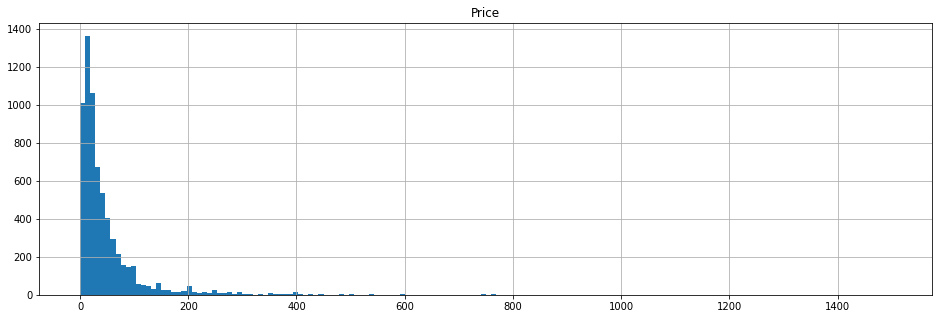

In [34]:
dfProd.hist(column='Price', bins=160, figsize=(16,5))

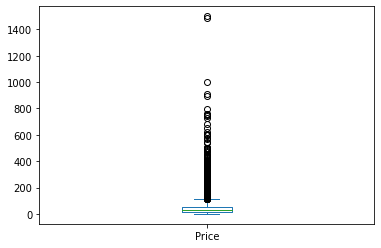

In [35]:
dfProd['Price'].plot.box()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc26e3df290>]],
      dtype=object)

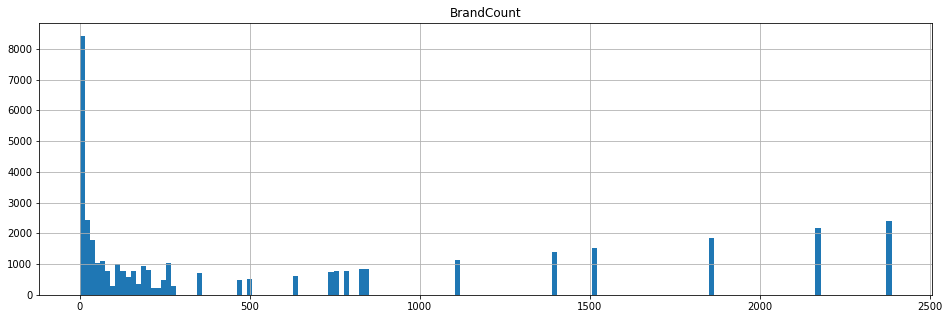

In [36]:
dfProd.hist(column='BrandCount', bins=160, figsize=(16,5))

## Reviews Data

### Data Cleaning

In [37]:
lenRevOrig = len(dfReviews)

In [38]:
# only keep reviews that has a valid product ASIN (ASIN exists in the products data)
dfReviews = dfReviews.loc[dfReviews['asin'].isin(dfProd['Asin'])]
lenRevClean = len(dfReviews)
print(str(lenRevOrig-lenRevClean), 'of', str(lenRevOrig), 'rows (', 
      '{:5.2f}'.format((lenRevOrig-lenRevClean)/lenRevOrig*100), ' %) are removed,',
      str(lenRevClean), 'remaining for analysis')

1079485 of 2565349 rows ( 42.08  %) are removed, 1485864 remaining for analysis


In [39]:
dfReviews['ReviewDate'] = pd.to_datetime(dfReviews['reviewTime'])

In [40]:
# convert vote to int
dfReviews['Vote'] = dfReviews['vote'].replace({',': ''}, regex=True)
dfReviews['Vote'] = dfReviews['Vote'].fillna(0)
dfReviews['Vote'] = dfReviews['Vote'].astype('float32').astype('Int32')

In [41]:
# rename overall to rating as it makes more sense and change data type to uint8 to save memory
dfReviews = dfReviews.rename(columns={'overall': 'Rating'})
dfReviews = dfReviews.astype({'Rating': np.uint8})

### Data Manipulation

#### Time

In [42]:
# compute review recentness
dfReviews['Recentness'] = ((dfReviews['ReviewDate'].max() + datetime.timedelta(days=1)) - dfReviews['ReviewDate']).dt.days
# dfReviews['recentness'] = (dfReviews['timeDiff'] / 90).astype(np.uint8) # 90 days = 3 months

In [43]:
# add dummy: whether before or after the ban of incentivized reviews (Oct 1, 2016)
dfReviews['IsAfterBan'] = dfReviews['ReviewDate'] >= pd.to_datetime('2016-10-01')

In [44]:
dfReviews['IsVerifiedAfterBan'] = dfReviews['IsAfterBan'] * dfReviews['verified']

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


#### Style

In [45]:
# get style keys
dfReviewsStyle = dfReviews.loc[(~dfReviews['style'].isna())]

dfReviewsStyle['styleStr'] = [list(d.keys()) for d in dfReviewsStyle['style']]
dfReviewsStyle['styleStr'] = [','.join(map(str, l)) for l in dfReviewsStyle['styleStr']]
dfReviewsStyle['styleStr'] = dfReviewsStyle['styleStr'].replace({':': ''}, regex=True)
dfReviewsStyle = dfReviewsStyle[['styleStr']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [46]:
# merge with dfReviews
dfReviews = dfReviews.merge(dfReviewsStyle, how='left', left_index=True, right_index=True)
dfReviews['styleStr'] = dfReviews['styleStr'].fillna('')

In [47]:
# count number of styles
dfReviews['NumStyles'] = dfReviews['style'].str.len()
dfReviews['NumStyles'] = dfReviews['NumStyles'].fillna(0)

#### Sentiment Analysis

In [48]:
dfReviewsBackup = dfReviews.copy()

In [49]:
dfReviews = dfReviews.reset_index(drop=True)

dfReviewsSeries = dfReviews.copy()
dfReviewsSeries = dfReviewsSeries[['reviewText']]
dfReviewsSeries['reviewText'] = dfReviewsSeries['reviewText'].astype(str)
dfReviewsSeries = dfReviewsSeries['reviewText'].squeeze()

In [50]:
sia = SentimentIntensityAnalyzer()
npReviewPolarity = np.zeros(len(dfReviewsSeries))

In [51]:
# get polarity score
i = 0
for text in dfReviewsSeries:
  # ps = sia.polarity_scores(text)
  npReviewPolarity[i] = sia.polarity_scores(text)['compound']
  i += 1

In [52]:
dfReviewSia = pd.DataFrame(npReviewPolarity, columns=['Sentiment'])

In [53]:
# merge into dfReviews
dfReviews = dfReviews.merge(dfReviewSia, left_index=True, right_index=True)

#### Selected Features

Select certain features (eg: Rating) based on verification status, IsAfterBan, etc., for aggregation later on.

In [56]:
dfReviewsMinTime = dfReviews.groupby(by=['asin']).agg({'Recentness': 'max'}).reset_index()
dfReviewsMinTime = dfReviewsMinTime.rename(columns={'Recentness': 'MaxRecentness'})
dfReviews = dfReviews.merge(dfReviewsMinTime, how='left', on='asin')

# dfReviews['MAXRecentness'] = dfReviews['Recentness'].max() + 1 
# MAXRecentness is absolute max recentness of all asin, MaxRecentness is local max recentness of each asin
dfReviews['ReverseRecentness'] = dfReviews['Recentness'].max() - dfReviews['Recentness'] + 1
dfReviews['RatingByRecentness'] = dfReviews['ReverseRecentness'] * dfReviews['Rating']
dfReviews['SentimentByRecentness'] = dfReviews['ReverseRecentness'] * dfReviews['Sentiment']

In [57]:
dfReviews['VerifiedRating'] = dfReviews['verified'] * dfReviews['Rating']
dfReviews['AfterBanRating'] = dfReviews['IsAfterBan'] * dfReviews['Rating']
dfReviews['VerifiedAfterBanRating'] = dfReviews['verified'] * dfReviews['IsAfterBan'] * dfReviews['Rating']

dfReviews['VerifiedSentiment'] = dfReviews['verified'] * dfReviews['Sentiment']
dfReviews['AfterBanSentiment'] = dfReviews['IsAfterBan'] * dfReviews['Sentiment']
dfReviews['VerifiedAfterBanSentiment'] = dfReviews['verified'] * dfReviews['IsAfterBan'] * dfReviews['Sentiment']

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


#### Others

In [58]:
# count number of images
dfReviews['NumReviewImages'] = dfReviews['image'].str.len()
dfReviews['NumReviewImages'] = dfReviews['NumReviewImages'].fillna(0)

# count review summary and review text lengths
dfReviews['LenReviewText'] = dfReviews['reviewText'].str.len()
dfReviews['LenReviewText'] = dfReviews['LenReviewText'].fillna(0)
dfReviews['LenSummary'] = dfReviews['summary'].str.len()
dfReviews['LenSummary'] = dfReviews['LenSummary'].fillna(0)

In [60]:
# change data types of some columns and select only the useful columns before proceeding to the next step
dfReviews = dfReviews.astype({'NumReviewImages': np.uint8, 'LenReviewText': np.int32,
                              'LenSummary': np.int32, 'NumStyles': np.uint8, 'Vote': np.int32})
dfReviews = dfReviews[['asin', 'Rating', 'RatingByRecentness', 'ReviewDate',
                       'verified', 'VerifiedRating', 'IsAfterBan', 'IsVerifiedAfterBan', 
                       'AfterBanRating', 'VerifiedAfterBanRating',
                       'Recentness', 'MaxRecentness', 'ReverseRecentness', 
                       'reviewerID', 'reviewText', 'LenReviewText', 'summary', 'LenSummary', 'Vote', 
                       'styleStr', 'NumStyles', 'NumReviewImages', 
                       'Sentiment', 'SentimentByRecentness', 
                       'VerifiedSentiment', 'AfterBanSentiment', 'VerifiedAfterBanSentiment']]
dfReviews = dfReviews.rename(columns={'asin': 'Asin', 'verified': 'IsVerified', 'reviewerID': 'ReviewerId',
                                      'reviewText': 'ReviewText', 'summary': 'Summary', 'styleStr': 'Style'})

In [61]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1485864 entries, 0 to 1485863
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Asin                       1485864 non-null  object        
 1   Rating                     1485864 non-null  uint8         
 2   RatingByRecentness         1485864 non-null  int64         
 3   ReviewDate                 1485864 non-null  datetime64[ns]
 4   IsVerified                 1485864 non-null  bool          
 5   VerifiedRating             1485864 non-null  uint8         
 6   IsAfterBan                 1485864 non-null  bool          
 7   IsVerifiedAfterBan         1485864 non-null  bool          
 8   AfterBanRating             1485864 non-null  uint8         
 9   VerifiedAfterBanRating     1485864 non-null  uint8         
 10  Recentness                 1485864 non-null  int64         
 11  MaxRecentness              1485864 no

In [62]:
dfReviews.describe(exclude='object', datetime_is_numeric=True)

,Rating,RatingByRecentness,ReviewDate,IsVerified,VerifiedRating,IsAfterBan,IsVerifiedAfterBan,AfterBanRating,VerifiedAfterBanRating,Recentness,...,LenReviewText,LenSummary,Vote,NumStyles,NumReviewImages,Sentiment,SentimentByRecentness,VerifiedSentiment,AfterBanSentiment,VerifiedAfterBanSentiment
count,1.485864e+06,1.485864e+06,1485864,1485864,1.485864e+06,1485864,1485864,1.485864e+06,1.485864e+06,1.485864e+06,...,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06,1.485864e+06
unique,NaN,NaN,NaN,2,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,True,NaN,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1015507,NaN,1269926,1290203,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.071494e+00,2.289889e+04,2013-03-03 07:22:43.163250688,NaN,2.871756e+00,NaN,NaN,5.987708e-01,5.493087e-01,2.039693e+03,...,4.756691e+02,2.275516e+01,1.801450e+00,7.889302e-01,1.029637e-02,5.239226e-01,2.852718e+03,3.526629e-01,6.387736e-02,5.834937e-02
min,1.000000e+00,5.000000e+00,1997-11-08 00:00:00,NaN,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-7.549080e+03,-9.999000e-01,-1.000000e+00,-9.996000e-01
25%,4.000000e+00,1.420500e+04,2011-05-19 00:00:00,NaN,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,9.950000e+02,...,5.600000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.446000e-01,1.438815e+03,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,2.564000e+04,2014-07-17 00:00:00,NaN,4.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,1.539000e+03,...,1.640000e+02,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,7.163000e-01,3.786301e+03,3.976000e-01,0.000000e+00,0.000000e+00
75%,5.000000e+00,3.162000e+04,2016-01-12 00:00:00,NaN,5.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,2.694000e+03,...,4.770000e+02,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,9.179000e-01,4.983762e+03,7.906000e-01,0.000000e+00,0.000000e+00
max,5.000000e+00,3.817000e+04,2018-10-02 00:00:00,NaN,5.000000e+00,NaN,NaN,5.000000e+00,5.000000e+00,7.634000e+03,...,3.272100e+04,3.000000e+02,5.154000e+03,3.000000e+00,4.800000e+01,1.000000e+00,7.609693e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [63]:
dfReviews.head()

,Asin,Rating,RatingByRecentness,ReviewDate,IsVerified,VerifiedRating,IsAfterBan,IsVerifiedAfterBan,AfterBanRating,VerifiedAfterBanRating,...,LenSummary,Vote,Style,NumStyles,NumReviewImages,Sentiment,SentimentByRecentness,VerifiedSentiment,AfterBanSentiment,VerifiedAfterBanSentiment
0,0439381673,1,6058,2014-06-09,True,1,False,False,0,0,...,17,0,,0,0,0.7430,4501.0940,0.7430,0.0,0.0
1,0439381673,3,18084,2014-05-10,True,3,False,False,0,0,...,14,0,,0,0,0.3603,2171.8884,0.3603,0.0,0.0
2,0439381673,4,23744,2014-02-07,True,4,False,False,0,0,...,59,15,,0,0,0.7579,4498.8944,0.7579,0.0,0.0
3,0439381673,1,5936,2014-02-07,True,1,False,False,0,0,...,24,11,,0,0,0.4810,2855.2160,0.4810,0.0,0.0
4,0439381673,4,23656,2014-01-16,True,4,False,False,0,0,...,11,0,,0,0,0.8470,5009.1580,0.8470,0.0,0.0


In [70]:
# save dfReviews to Drive for easier access later on
dfReviewsJson = dfReviews.copy()
dfReviewsJson['ReviewDate'] = dfReviewsJson['ReviewDate'].dt.strftime('%Y-%m-%d')
dfReviewsJson['Sentiment'] = dfReviewsJson['Sentiment'].round(4).astype(str)
dfReviewsJson.to_json('gdrive/MyDrive/amazon_data/clean_dfReviews.json', orient='split')

In [65]:
# retrieve the dfReviews json file
dfReviews = pd.read_json('gdrive/MyDrive/amazon_data/clean_dfReviews.json', orient='split')
dfReviews['ReviewDate'] = pd.to_datetime(dfReviews['ReviewDate'])

### Summary & Plots

In [71]:
# rating distribution by verified vs. unverified, and before vs. after ban
dfRevRatingDistbSum = pd.concat([dfReviews.groupby(['Rating', 'IsVerified']).size(),
                                 dfReviews.groupby(['Rating', 'IsAfterBan']).size()],
                                axis=1).unstack().reset_index()
dfRevRatingDistbSum = dfRevRatingDistbSum.rename(columns={0: 'Verification Status', 1: 'Before or After Ban'}, level=0)

# rating distribution of all samples
dfRevRatingDistb = dfReviews['Rating'].value_counts().sort_index().to_frame()
dfRevRatingDistb = dfRevRatingDistb.rename(columns={'Rating': 'Full Sample'})
dfRevRatingDistb.columns = pd.MultiIndex.from_product([dfRevRatingDistb.columns, ['Size']])
dfRevRatingDistb = dfRevRatingDistb.reset_index()
dfRevRatingDistb = dfRevRatingDistb.rename(columns={'index': 'Rating'})

dfRevRatingDistbSum = dfRevRatingDistb.merge(dfRevRatingDistbSum, on='Rating')

# calculate percentage
dfRevRatingDistbSum['Full Sample','Percentage'] = dfRevRatingDistbSum['Full Sample','Size']\
                                              /dfRevRatingDistbSum['Full Sample','Size'].sum()*100
dfRevRatingDistbSum['Verification Status', 'TruePercentage'] = dfRevRatingDistbSum['Verification Status', True]\
                                            /dfRevRatingDistbSum['Verification Status', True].sum()*100
dfRevRatingDistbSum['Verification Status', 'FalsePercentage'] = dfRevRatingDistbSum['Verification Status', False]\
                                            /dfRevRatingDistbSum['Verification Status', False].sum()*100
dfRevRatingDistbSum['Before or After Ban', 'TruePercentage'] = dfRevRatingDistbSum['Before or After Ban', True]\
                                            /dfRevRatingDistbSum['Before or After Ban', True].sum()*100
dfRevRatingDistbSum['Before or After Ban', 'FalsePercentage'] = dfRevRatingDistbSum['Before or After Ban', False]\
                                            /dfRevRatingDistbSum['Before or After Ban', False].sum()*100

dfRevRatingDistbSum = dfRevRatingDistbSum[['Rating', 'Full Sample', 'Verification Status', 'Before or After Ban']]
dfRevRatingDistbSum = dfRevRatingDistbSum.append(dfRevRatingDistbSum.sum(), ignore_index=True)
dfRevRatingDistbSum['Rating', ''][5] = ''

dfRevRatingDistbSum

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Rating Full Sample             Verification Status             \
                Size  Percentage               False       True   
0    1.0    163285.0   10.989229             68090.0    95195.0   
1    2.0     76056.0    5.118638             35024.0    41032.0   
2    3.0    124899.0    8.405816             48357.0    76542.0   
3    4.0    248527.0   16.726093             94991.0   153536.0   
4    5.0    873097.0   58.760223            223895.0   649202.0   
5          1485864.0  100.000000            470357.0  1015507.0   

                                 Before or After Ban                           \
  TruePercentage FalsePercentage               False      True TruePercentage   
0       9.374135       14.476238            135048.0   28237.0      13.076439   
1       4.040543        7.446259             67410.0    8646.0       4.003927   
2       7.537319       10.280914            111329.0   13570.0       6.284211   
3      15.119147       20.195511            224555.0   23972.0      11.101335   
4      63.928855       47.601077            731584.0  141513.0      65.534088   
5     100.000000      100.000000           1269926.0  215938.0     100.000000   

                   
  FalsePercentage  
0       10.634320  
1        5.308183  
2        8.766574  
3       17.682526  
4       57.608396  
5      100.000000

In [178]:
print(dfRevRatingDistbSum.to_latex(index=False, 
                             columns=[('Rating', ''), ('Full Sample', 'Percentage'),
                                      ('Verification Status', 'TruePercentage'), ('Verification Status', 'FalsePercentage'),
                                      ('Before or After Ban', 'TruePercentage'), ('Before or After Ban', 'FalsePercentage')],
                             float_format="{:0.2f}\%".format,
                             escape=False))

\begin{tabular}{lrrrrr}
\toprule
Rating & Full Sample & \multicolumn{2}{l}{Verification Status} & \multicolumn{2}{l}{Before or After Ban} \\
       &  Percentage &      TruePercentage & FalsePercentage &      TruePercentage & FalsePercentage \\
\midrule
1.00\% &     10.99\% &              9.37\% &         14.48\% &             13.08\% &         10.63\% \\
2.00\% &      5.12\% &              4.04\% &          7.45\% &              4.00\% &          5.31\% \\
3.00\% &      8.41\% &              7.54\% &         10.28\% &              6.28\% &          8.77\% \\
4.00\% &     16.73\% &             15.12\% &         20.20\% &             11.10\% &         17.68\% \\
5.00\% &     58.76\% &             63.93\% &         47.60\% &             65.53\% &         57.61\% \\
       &    100.00\% &            100.00\% &        100.00\% &            100.00\% &        100.00\% \\
\bottomrule
\end{tabular}



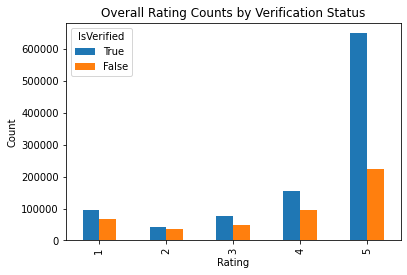

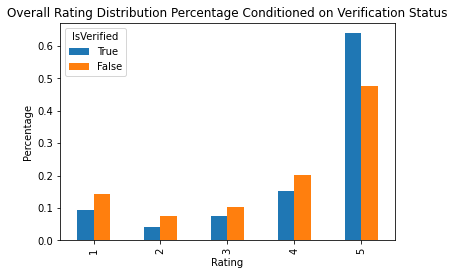

In [73]:
# rating distribution - graph
dfRatingsByVerified = dfReviews.groupby('IsVerified', sort=False).Rating.value_counts(normalize=False).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Count', title='Overall Rating Counts by Verification Status')

dfRatingsByVerified = dfReviews.groupby('IsVerified', sort=False).Rating.value_counts(normalize=True).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Percentage', 
                            title='Overall Rating Distribution Percentage Conditioned on Verification Status')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc21e020750>]],
      dtype=object)

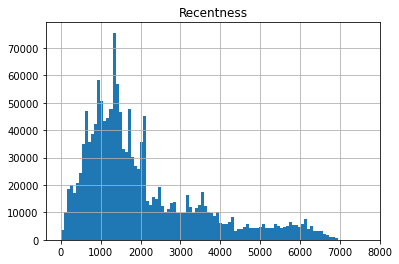

In [74]:
# review recentness
dfReviews.hist(column='Recentness', bins=100)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


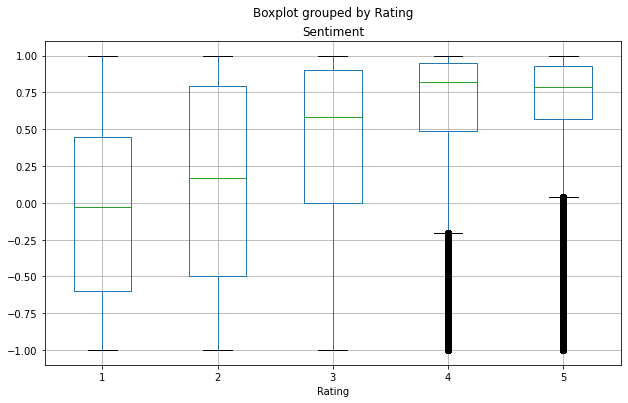

In [75]:
dfReviews.boxplot(column='Sentiment', by='Rating', figsize=(10,6))

## Aggregate Reviews Data by Product

In [76]:
dfAggr = dfReviews.groupby(['Asin'], as_index=False).agg({'ReverseRecentness': np.sum,
                                                          'Rating': 'mean',
                                                          'RatingByRecentness': np.sum,
                                                          'VerifiedRating': np.sum,
                                                          'AfterBanRating': np.sum,
                                                          'VerifiedAfterBanRating': np.sum,
                                                          'ReviewerId': 'count', 
                                                          'IsVerified': np.sum, 
                                                          'IsAfterBan': np.sum, 
                                                          'IsVerifiedAfterBan': np.sum, 
                                                          'Sentiment': 'mean',
                                                          'SentimentByRecentness': np.sum,
                                                          'VerifiedSentiment': np.sum,
                                                          'AfterBanSentiment': np.sum,
                                                          'VerifiedAfterBanSentiment': np.sum,
                                                          'NumReviewImages': np.sum})

dfAggr = dfAggr.rename(columns={'ReverseRecentness': 'TotalReverseRecentness',
                                'Rating': 'MeanRating', 
                                'RatingByRecentness': 'TotalRatingByRecentness',
                                'VerifiedRating': 'TotalVerifiedRating',
                                'AfterBanRating': 'TotalAfterBanRating',
                                'VerifiedAfterBanRating': 'TotalVerifiedAfterBanRating',
                                'ReviewerId': 'NumReviews',
                                'IsVerified': 'NumVerifiedReviews', 
                                'IsAfterBan': 'NumReviewsAfterBan',
                                'IsVerifiedAfterBan': 'NumVerifiedReviewsAfterBan', 
                                'Sentiment': 'MeanSentiment',
                                'SentimentByRecentness': 'TotalSentimentByRecentness',
                                'VerifiedSentiment': 'TotalVerifiedSentiment', 
                                'AfterBanSentiment': 'TotalAfterBanSentiment',
                                'VerifiedAfterBanSentiment': 'TotalVerifiedAfterBanSentiment',
                                'NumReviewImages': 'TotalNumReviewImages'})

dfAggr['VerifiedPercentage'] = dfAggr['NumVerifiedReviews'] / dfAggr['NumReviews']
dfAggr['AfterBanPercentage'] = dfAggr['NumReviewsAfterBan'] / dfAggr['NumReviews']
dfAggr['VerifiedAfterBanPercentage'] = dfAggr['NumVerifiedReviewsAfterBan'] / dfAggr['NumReviews']

dfAggr['MeanRatingByRecentness'] = dfAggr['TotalRatingByRecentness'] / dfAggr['TotalReverseRecentness']
dfAggr['MeanVerifiedRating'] = dfAggr['TotalVerifiedRating'] / dfAggr['NumVerifiedReviews']
dfAggr['MeanAfterBanRating'] = dfAggr['TotalAfterBanRating'] / dfAggr['NumReviewsAfterBan']
dfAggr['MeanVerifiedAfterBanRating'] = dfAggr['TotalVerifiedAfterBanRating'] / dfAggr['NumVerifiedReviewsAfterBan']

dfAggr['MeanSentimentByRecentness'] = dfAggr['TotalSentimentByRecentness'] / dfAggr['TotalReverseRecentness']
dfAggr['MeanVerifiedSentiment'] = dfAggr['TotalVerifiedSentiment'] / dfAggr['NumVerifiedReviews']
dfAggr['MeanAfterBanSentiment'] = dfAggr['TotalAfterBanSentiment'] / dfAggr['NumReviewsAfterBan']
dfAggr['MeanVerifiedAfterBanSentiment'] = dfAggr['TotalVerifiedAfterBanSentiment'] / dfAggr['NumVerifiedReviewsAfterBan']

dfAggr = dfAggr.fillna(0)

In [77]:
dfProd = dfProd.merge(dfAggr, on='Asin')

In [97]:
dfProd.describe()

,BrandCount,Price,RankVideoGames,RankCategory2,RankCategory3,RankCategory4,NumImages,NumHighResImages,NumDetails,LenFeature,...,AfterBanPercentage,VerifiedAfterBanPercentage,MeanRatingByRecentness,MeanVerifiedRating,MeanAfterBanRating,MeanVerifiedAfterBanRating,MeanSentimentByRecentness,MeanVerifiedSentiment,MeanAfterBanSentiment,MeanVerifiedAfterBanSentiment
count,39990.000000,6632.000000,39990.000000,37686.000000,8135.000000,5277.000000,39990.000000,39990.000000,39990.000000,39990.000000,...,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000
mean,632.344586,48.312666,66102.663491,4449.690124,3476.390904,6798.765966,3.037209,3.037209,0.008077,264.128007,...,0.153617,0.142751,3.862919,3.605552,2.063532,2.025666,0.477886,0.434045,0.214402,0.209933
std,791.128886,73.608438,49716.745976,9252.325222,7588.316581,7193.847903,3.086411,3.086411,0.212302,356.849138,...,0.268307,0.256154,1.014699,1.478811,2.162662,2.169198,0.323749,0.335831,0.326398,0.323108
min,0.000000,0.010000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.999700,-0.997800,-0.999200,-0.997600
25%,24.000000,13.867500,26808.000000,447.000000,521.500000,702.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,3.401550,3.000000,0.000000,0.000000,0.345038,0.254730,0.000000,0.000000
50%,189.000000,26.365000,55364.000000,1328.000000,1920.000000,4684.000000,2.000000,2.000000,0.000000,122.000000,...,0.024412,0.016129,4.059952,4.047619,1.000000,1.000000,0.530775,0.500755,0.000000,0.000000
75%,1116.000000,54.472500,93495.000000,5526.500000,4404.500000,10916.000000,6.000000,6.000000,0.000000,418.000000,...,0.166667,0.153846,4.593227,4.666667,4.409091,4.428571,0.680645,0.658800,0.482173,0.475629
max,2387.000000,1500.000000,241788.000000,510637.000000,509623.000000,186146.000000,14.000000,14.000000,7.000000,7993.000000,...,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,0.999900,0.999400,0.998700,0.998700


### Plots

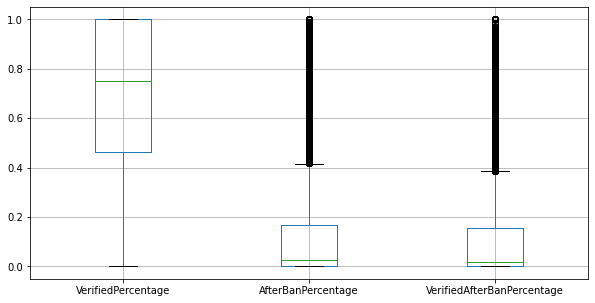

In [78]:
dfProd.boxplot(column=['VerifiedPercentage', 'AfterBanPercentage', 'VerifiedAfterBanPercentage'],
               figsize=(10,5))

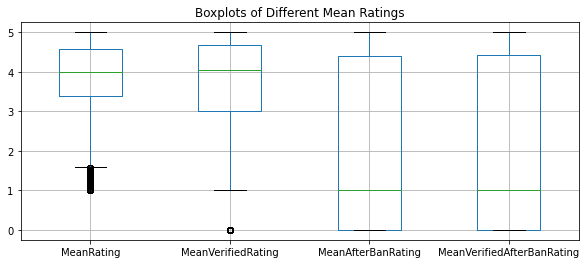

In [82]:
# Boxplots of Different Mean Ratings
plt.figure(figsize=(10,4))
dfProd.boxplot(column=['MeanRating', 'MeanVerifiedRating', 'MeanAfterBanRating', 'MeanVerifiedAfterBanRating'],
               figsize=(10,5))
plt.title('Boxplots of Different Mean Ratings')
plt.show()

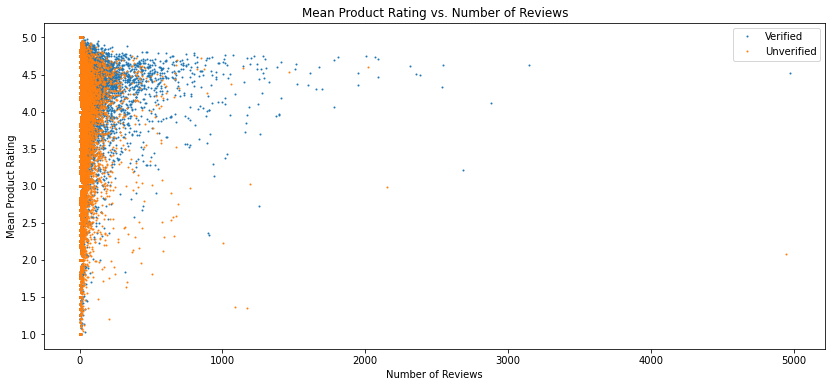

In [81]:
# Mean Product Rating vs. Number of Reviews
gcAsinVer = dfReviews.groupby(['Asin', 'IsVerified'], as_index=False).agg({'Rating': 'mean', 'ReviewerId': 'count'})
gcAsinVer = gcAsinVer.rename(columns={'Rating': 'MeanRating', 'ReviewerId': 'NumReviews'})

# plot scatterplot of ratings vs. number of reviews per product for verified and unverified reviews respectively
gcVerified = gcAsinVer.loc[gcAsinVer['IsVerified'] == True]
gcUnverified = gcAsinVer.loc[gcAsinVer['IsVerified'] == False]

plt.figure(figsize=(14,6))
plt.plot(gcVerified['NumReviews'], gcVerified['MeanRating'], '.', markersize=2, label='Verified')
plt.plot(gcUnverified['NumReviews'], gcUnverified['MeanRating'], '.', markersize=2, label='Unverified')
plt.title('Mean Product Rating vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Product Rating')
plt.legend()
plt.show()

## Regression

### Correlation & Multicolliearity

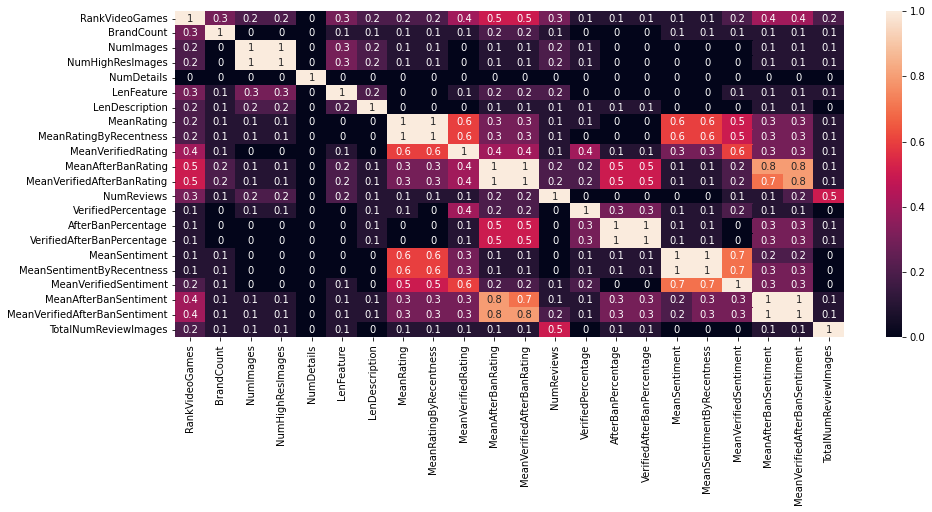

In [83]:
# correlation matrix
dfProdCorr = dfProd.copy()
dfProdCorr = dfProdCorr[['RankVideoGames', 'BrandCount', #'RankCategory2', 'RankCategory3', 'RankCategory4',
                         'NumImages', 'NumHighResImages', 'NumDetails', 'LenFeature', 'LenDescription',
                         'MeanRating', 'MeanRatingByRecentness', 'MeanVerifiedRating', 
                         'MeanAfterBanRating', 'MeanVerifiedAfterBanRating',
                         'NumReviews', #'NumVerifiedReviews', 'NumReviewsAfterBan', 'NumVerifiedReviewsAfterBan', 
                         'VerifiedPercentage', 'AfterBanPercentage','VerifiedAfterBanPercentage',
                         'MeanSentiment', 'MeanSentimentByRecentness', 'MeanVerifiedSentiment', 
                         'MeanAfterBanSentiment', 'MeanVerifiedAfterBanSentiment',
                         'TotalNumReviewImages'
                         ]]
dfAggrCorr = dfProdCorr.corr()
dfAggrCorr = dfAggrCorr.abs()
dfAggrCorr = dfAggrCorr.round(1)

plt.figure(figsize=(15, 6))
sns.heatmap(dfAggrCorr, annot=True)

In [85]:
# a function that returns VIF of varList, a list of variables in dfProd, to test multicollinearity
def multicorr(varList):
  dfAggrVif = dfProd.copy()
  dfAggrVif = dfAggrVif[varList]

  dfVif = pd.DataFrame()
  dfVif['Variables'] = dfAggrVif.columns
  dfVif["VIF"] = [variance_inflation_factor(dfAggrVif.values,i) for i in range(dfAggrVif.shape[1])]

  return dfVif

In [175]:
# sample multicollinear variables
dfMulticorr = multicorr(['RankVideoGames', 'MeanRating', 'MeanSentiment', 'NumReviews', 
                         'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])
print(dfMulticorr)
print(dfMulticorr.to_latex(header=True, index=False, float_format='{:0.2f}'.format))

              Variables        VIF
0        RankVideoGames   2.424491
1            MeanRating  10.884210
2         MeanSentiment   4.764433
3            NumReviews   1.447195
4    VerifiedPercentage   5.042495
5    AfterBanPercentage   1.504288
6  TotalNumReviewImages   1.336071
\begin{tabular}{lr}
\toprule
           Variables &   VIF \\
\midrule
      RankVideoGames &  2.42 \\
          MeanRating & 10.88 \\
       MeanSentiment &  4.76 \\
          NumReviews &  1.45 \\
  VerifiedPercentage &  5.04 \\
  AfterBanPercentage &  1.50 \\
TotalNumReviewImages &  1.34 \\
\bottomrule
\end{tabular}



### Basic Model

In [104]:
# scale all columns other than RankVideoGames such that each column has a mean of 100, 
# to see which variable has the largest impact in the regression models
# note that correlation matrix and VIF tests are still done based on unscaled data
# and scaled data is used in linear regression models only
dfProdScaled = dfProd.copy()
dfProdScaled = dfProdScaled.select_dtypes(exclude='object')

for c in dfProdScaled.columns:
  if c != 'RankVideoGames':
    dfProdScaled[c] = dfProdScaled[c]/dfProdScaled[c].mean()*100

In [105]:
dfProdScaled.describe()

,BrandCount,Price,RankVideoGames,RankCategory2,RankCategory3,RankCategory4,NumImages,NumHighResImages,NumDetails,LenFeature,...,AfterBanPercentage,VerifiedAfterBanPercentage,MeanRatingByRecentness,MeanVerifiedRating,MeanAfterBanRating,MeanVerifiedAfterBanRating,MeanSentimentByRecentness,MeanVerifiedSentiment,MeanAfterBanSentiment,MeanVerifiedAfterBanSentiment
count,39990.000000,6632.000000,39990.000000,37686.000000,8135.000000,5277.000000,39990.000000,39990.000000,39990.000000,39990.000000,...,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000,39990.000000
mean,100.000000,100.000000,66102.663491,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
std,125.110407,152.358468,49716.745976,207.931900,218.281453,105.811083,101.619978,101.619978,2628.470636,135.104619,...,174.660241,179.441666,26.267662,41.014832,104.803896,107.085673,67.746155,77.372439,152.236259,153.910306
min,0.000000,0.020699,2.000000,0.022473,0.028765,0.014709,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,25.887159,0.000000,0.000000,0.000000,-209.192250,-229.884015,-466.039778,-475.200192
25%,3.795399,28.703653,26808.000000,10.045643,15.001190,10.325403,32.924962,32.924962,0.000000,0.000000,...,0.000000,0.000000,88.056469,83.205012,0.000000,0.000000,72.200843,58.687572,0.000000,0.000000
50%,29.888767,54.571611,55364.000000,29.844775,55.229692,68.894856,65.849923,65.849923,0.000000,46.189725,...,15.891206,11.298742,105.100631,112.260731,48.460610,49.366483,111.067358,115.369477,0.000000,0.000000
75%,176.486053,112.749936,93495.000000,124.199660,126.697490,160.558549,197.549770,197.549770,0.000000,158.256599,...,108.495237,107.772619,118.905591,129.430019,213.667235,218.622997,142.428412,151.781508,224.891862,226.562822
max,377.484057,3104.775887,241788.000000,11475.787882,14659.542443,2737.938046,460.949464,460.949464,86665.634675,3026.184194,...,650.971422,700.522022,129.435794,138.675021,242.303050,246.832416,209.234101,230.252640,465.806572,475.724169


#### 1 Mean rating of all reviews

In [133]:
multicorr(['RankVideoGames', 'MeanRating', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.413110
1,MeanRating,5.287858
2,NumReviews,1.446710
3,VerifiedPercentage,4.926020
4,AfterBanPercentage,1.490919
5,TotalNumReviewImages,1.336039


In [134]:
regBasic1 = ols(formula="RankVideoGames ~ MeanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic1.summary()#.as_latex()
# for table in results.summary().tables:
    # print(table.as_latex_tabular())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1109.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:28   Log-Likelihood:            -4.8660e+05
No. Observations:               39990   AIC:                         9.732e+05
Df Residuals:                   39984   BIC:                         9.733e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.124e+05   1015.575    110.634      0.000     1.1e+05    1.14e+05
MeanRating            -343.2671      8.913    -38.513      0.000    -360.737    -325.797
NumReviews             -34.5141      0.744    -46.370      0.000     -35.973     -33.055
VerifiedPercentage     -55.5194      5.042    -11.011      0.000     -65.402     -45.637
AfterBanPercentage     -28.0218      1.407    -19.917      0.000     -30.779     -25.264
TotalNumReviewImages    -1.2226      0.444     -2.753      0.006      -2.093      -0.352
==============================================================================
Omnibus:                     8629.489   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18917.277
Skew:                           1.247   Prob(JB):                         0.00
Kurtosis:                       5.265   Cond. No.                     2.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2 Mean sentiment of all reviews

In [135]:
multicorr(['RankVideoGames', 'MeanSentiment', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.145657
1,MeanSentiment,2.314697
2,NumReviews,1.419176
3,VerifiedPercentage,3.402044
4,AfterBanPercentage,1.491831
5,TotalNumReviewImages,1.336062


In [136]:
regBasic2 = ols(formula="RankVideoGames ~ MeanSentiment + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     897.7
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:29   Log-Likelihood:            -4.8707e+05
No. Observations:               39990   AIC:                         9.742e+05
Df Residuals:                   39984   BIC:                         9.742e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8.799e+04    667.376    131.850      0.000    8.67e+04    8.93e+04
MeanSentiment          -80.3430      3.526    -22.789      0.000     -87.253     -73.433
NumReviews             -35.3510      0.753    -46.970      0.000     -36.826     -33.876
VerifiedPercentage     -70.5210      5.105    -13.814      0.000     -80.527     -60.515
AfterBanPercentage     -31.2097      1.426    -21.882      0.000     -34.005     -28.414
TotalNumReviewImages    -1.4806      0.449     -3.295      0.001      -2.361      -0.600
==============================================================================
Omnibus:                     8626.016   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19131.519
Skew:                           1.241   Prob(JB):                         0.00
Kurtosis:                       5.307   Cond. No.                     1.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 3 Mean rating of all verified reviews

In [137]:
multicorr(['RankVideoGames', 'MeanVerifiedRating', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.013725
1,MeanVerifiedRating,5.607319
2,NumReviews,1.432177
3,VerifiedPercentage,6.771685
4,AfterBanPercentage,1.490310
5,TotalNumReviewImages,1.335964


In [138]:
regBasic3 = ols(formula="RankVideoGames ~ MeanVerifiedRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     2287.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:29   Log-Likelihood:            -4.8417e+05
No. Observations:               39990   AIC:                         9.684e+05
Df Residuals:                   39984   BIC:                         9.684e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.101e+05    628.542    175.184      0.000    1.09e+05    1.11e+05
MeanVerifiedRating    -492.1120      5.948    -82.734      0.000    -503.770    -480.454
NumReviews             -30.2973      0.703    -43.106      0.000     -31.675     -28.920
VerifiedPercentage     115.9861      5.215     22.239      0.000     105.764     126.209
AfterBanPercentage     -32.2020      1.324    -24.318      0.000     -34.797     -29.607
TotalNumReviewImages    -1.4521      0.418     -3.475      0.001      -2.271      -0.633
==============================================================================
Omnibus:                     7615.051   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15276.145
Skew:                           1.148   Prob(JB):                         0.00
Kurtosis:                       4.974   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 4 Mean rating of all reviews after the ban

In [139]:
multicorr(['RankVideoGames', 'MeanAfterBanRating', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.081827
1,MeanAfterBanRating,2.566253
2,NumReviews,1.479203
3,VerifiedPercentage,3.482306
4,AfterBanPercentage,1.865670
5,TotalNumReviewImages,1.336968


In [140]:
regBasic4 = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     3436.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:29   Log-Likelihood:            -4.8205e+05
No. Observations:               39990   AIC:                         9.641e+05
Df Residuals:                   39984   BIC:                         9.642e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.486e+04    499.843    189.775      0.000    9.39e+04    9.58e+04
MeanAfterBanRating    -258.0601      2.348   -109.893      0.000    -262.663    -253.457
NumReviews             -18.2558      0.682    -26.750      0.000     -19.593     -16.918
VerifiedPercentage     -54.6850      4.496    -12.162      0.000     -63.498     -45.872
AfterBanPercentage      45.8423      1.429     32.085      0.000      43.042      48.643
TotalNumReviewImages    -2.3916      0.396     -6.034      0.000      -3.168      -1.615
==============================================================================
Omnibus:                     5432.189   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8679.825
Skew:                           0.948   Prob(JB):                         0.00
Kurtosis:                       4.271   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [167]:
dfRegBasic4 = pd.read_html(regBasic4.summary().tables[1].as_html(), header=0, index_col=0)[0]#.as_latex_tabular()
dfRegBasic4 = dfRegBasic4[['coef', 'std err', '[0.025', '0.975]']]
dfRegBasic4

,coef,std err,[0.025,0.975]
Intercept,94860.0000,499.843,93900.000,95800.000
MeanAfterBanRating,-258.0601,2.348,-262.663,-253.457
NumReviews,-18.2558,0.682,-19.593,-16.918
VerifiedPercentage,-54.6850,4.496,-63.498,-45.872
AfterBanPercentage,45.8423,1.429,43.042,48.643
TotalNumReviewImages,-2.3916,0.396,-3.168,-1.615


In [176]:
print(dfRegBasic4.to_latex(index=True, float_format='{:0.2f}'.format))

\begin{tabular}{lrrrr}
\toprule
{} &     coef &  std err &   [0.025 &   0.975] \\
\midrule
Intercept            & 94860.00 &   499.84 & 93900.00 & 95800.00 \\
MeanAfterBanRating   &  -258.06 &     2.35 &  -262.66 &  -253.46 \\
NumReviews           &   -18.26 &     0.68 &   -19.59 &   -16.92 \\
VerifiedPercentage   &   -54.69 &     4.50 &   -63.50 &   -45.87 \\
AfterBanPercentage   &    45.84 &     1.43 &    43.04 &    48.64 \\
TotalNumReviewImages &    -2.39 &     0.40 &    -3.17 &    -1.61 \\
\bottomrule
\end{tabular}



#### 5 Mean rating of all verified reviews after the ban

In [141]:
multicorr(['RankVideoGames', 'MeanVerifiedAfterBanRating', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.101765
1,MeanVerifiedAfterBanRating,2.542366
2,NumReviews,1.479088
3,VerifiedPercentage,3.544432
4,AfterBanPercentage,1.826738
5,TotalNumReviewImages,1.336828


In [142]:
regBasic5 = ols(formula="RankVideoGames ~ MeanVerifiedAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     3420.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:30   Log-Likelihood:            -4.8208e+05
No. Observations:               39990   AIC:                         9.642e+05
Df Residuals:                   39984   BIC:                         9.642e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   9.298e+04    495.627    187.600      0.000     9.2e+04     9.4e+04
MeanVerifiedAfterBanRating  -249.8898      2.280   -109.578      0.000    -254.360    -245.420
NumReviews                   -18.0928      0.683    -26.477      0.000     -19.432     -16.753
VerifiedPercentage           -39.6170      4.504     -8.796      0.000     -48.445     -30.789
AfterBanPercentage            41.1259      1.410     29.160      0.000      38.362      43.890
TotalNumReviewImages          -2.2940      0.397     -5.784      0.000      -3.071      -1.517
==============================================================================
Omnibus:                     5577.636   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9039.458
Skew:                           0.962   Prob(JB):                         0.00
Kurtosis:                       4.313   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6 Mean sentiment of all verified reviews

In [143]:
multicorr(['RankVideoGames', 'MeanVerifiedSentiment', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,1.998073
1,MeanVerifiedSentiment,2.441936
2,NumReviews,1.411786
3,VerifiedPercentage,4.090154
4,AfterBanPercentage,1.498730
5,TotalNumReviewImages,1.335948


In [144]:
regBasic6 = ols(formula="RankVideoGames ~ MeanVerifiedSentiment + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1220.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:30   Log-Likelihood:            -4.8636e+05
No. Observations:               39990   AIC:                         9.727e+05
Df Residuals:                   39984   BIC:                         9.728e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               8.84e+04    572.339    154.455      0.000    8.73e+04    8.95e+04
MeanVerifiedSentiment  -136.7868      3.067    -44.594      0.000    -142.799    -130.775
NumReviews              -34.0035      0.740    -45.940      0.000     -35.454     -32.553
VerifiedPercentage      -16.4926      5.119     -3.222      0.001     -26.526      -6.459
AfterBanPercentage      -34.2211      1.403    -24.394      0.000     -36.971     -31.471
TotalNumReviewImages     -1.4786      0.441     -3.350      0.001      -2.344      -0.614
==============================================================================
Omnibus:                     8408.457   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18149.155
Skew:                           1.224   Prob(JB):                         0.00
Kurtosis:                       5.214   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 7 Mean sentiment of all reviews after the ban

In [145]:
multicorr(['RankVideoGames', 'MeanAfterBanSentiment', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.034507
1,MeanAfterBanSentiment,1.624542
2,NumReviews,1.428467
3,VerifiedPercentage,3.038641
4,AfterBanPercentage,1.632947
5,TotalNumReviewImages,1.335987


In [146]:
regBasic7 = ols(formula="RankVideoGames ~ MeanAfterBanSentiment + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     1753.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:31   Log-Likelihood:            -4.8524e+05
No. Observations:               39990   AIC:                         9.705e+05
Df Residuals:                   39984   BIC:                         9.705e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              8.566e+04    527.827    162.284      0.000    8.46e+04    8.67e+04
MeanAfterBanSentiment  -105.4546      1.587    -66.438      0.000    -108.566    -102.343
NumReviews              -28.8760      0.726    -39.772      0.000     -30.299     -27.453
VerifiedPercentage      -60.5405      4.868    -12.435      0.000     -70.083     -50.998
AfterBanPercentage        0.9247      1.433      0.645      0.519      -1.883       3.733
TotalNumReviewImages     -1.6074      0.429     -3.746      0.000      -2.448      -0.766
==============================================================================
Omnibus:                     7058.851   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13025.320
Skew:                           1.111   Prob(JB):                         0.00
Kurtosis:                       4.696   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 8 Mean sentiment of all verified reviews after the ban

In [147]:
multicorr(['RankVideoGames', 'MeanVerifiedAfterBanSentiment', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.043265
1,MeanVerifiedAfterBanSentiment,1.626924
2,NumReviews,1.429280
3,VerifiedPercentage,3.068098
4,AfterBanPercentage,1.620971
5,TotalNumReviewImages,1.335978


In [148]:
regBasic8 = ols(formula="RankVideoGames ~ MeanVerifiedAfterBanSentiment + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1777.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:31   Log-Likelihood:            -4.8519e+05
No. Observations:               39990   AIC:                         9.704e+05
Df Residuals:                   39984   BIC:                         9.704e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      8.508e+04    525.464    161.911      0.000     8.4e+04    8.61e+04
MeanVerifiedAfterBanSentiment  -105.3189      1.566    -67.259      0.000    -108.388    -102.250
NumReviews                      -28.5579      0.726    -39.354      0.000     -29.980     -27.136
VerifiedPercentage              -54.2604      4.864    -11.155      0.000     -63.794     -44.726
AfterBanPercentage               -0.0304      1.425     -0.021      0.983      -2.823       2.763
TotalNumReviewImages             -1.5899      0.429     -3.710      0.000      -2.430      -0.750
==============================================================================
Omnibus:                     7040.733   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12952.864
Skew:                           1.110   Prob(JB):                         0.00
Kurtosis:                       4.686   Cond. No.                     1.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 9 Mean rating & sentiment of all reviews after the ban

In [149]:
multicorr(['RankVideoGames', 'MeanAfterBanRating', 'MeanAfterBanSentiment', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages'])

,Variables,VIF
0,RankVideoGames,2.082229
1,MeanAfterBanRating,5.459025
2,MeanAfterBanSentiment,3.455785
3,NumReviews,1.481833
4,VerifiedPercentage,3.492564
5,AfterBanPercentage,1.875369
6,TotalNumReviewImages,1.337552


In [150]:
regBasic9 = ols(formula="RankVideoGames ~ MeanAfterBanRating + MeanAfterBanSentiment + NumReviews \
                         + VerifiedPercentage + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdScaled).fit()
regBasic9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     2892.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:32   Log-Likelihood:            -4.8199e+05
No. Observations:               39990   AIC:                         9.640e+05
Df Residuals:                   39983   BIC:                         9.641e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.506e+04    499.449    190.338      0.000    9.41e+04     9.6e+04
MeanAfterBanRating     -285.0690      3.397    -83.917      0.000    -291.727    -278.411
MeanAfterBanSentiment    23.2996      2.120     10.988      0.000      19.144      27.456
NumReviews              -17.9412      0.682    -26.305      0.000     -19.278     -16.604
VerifiedPercentage      -54.4741      4.490    -12.133      0.000     -63.274     -45.674
AfterBanPercentage       47.0497      1.431     32.882      0.000      44.245      49.854
TotalNumReviewImages     -2.4785      0.396     -6.262      0.000      -3.254      -1.703
==============================================================================
Omnibus:                     5401.514   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8617.385
Skew:                           0.944   Prob(JB):                         0.00
Kurtosis:                       4.268   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Heterogeneity test

In [151]:
multicorr(['RankVideoGames', 'MeanAfterBanRating', 'NumReviews', 
           'VerifiedPercentage', 'AfterBanPercentage', 'TotalNumReviewImages',
           'BrandCount', 'NumHighResImages', 'NumDetails', 'LenFeature', 'LenDescription'])

,Variables,VIF
0,RankVideoGames,2.152064
1,MeanAfterBanRating,3.022661
2,NumReviews,1.536995
3,VerifiedPercentage,4.017707
4,AfterBanPercentage,1.967418
5,TotalNumReviewImages,1.339506
6,BrandCount,1.645595
7,NumHighResImages,2.136758
8,NumDetails,1.002475
9,LenFeature,1.795051


In [152]:
regHetero = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages \
                         + BrandCount + NumHighResImages + NumDetails + LenFeature + LenDescription",
                data=dfProdScaled).fit()
regHetero.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     2233.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:41:33   Log-Likelihood:            -4.8033e+05
No. Observations:               39990   AIC:                         9.607e+05
Df Residuals:                   39979   BIC:                         9.608e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.086e+05    542.037    200.399      0.000    1.08e+05     1.1e+05
MeanAfterBanRating    -219.3435      2.341    -93.678      0.000    -223.933    -214.754
NumReviews             -11.5072      0.665    -17.293      0.000     -12.811     -10.203
VerifiedPercentage     -65.3048      4.356    -14.993      0.000     -73.842     -56.767
AfterBanPercentage      32.7075      1.390     23.527      0.000      29.983      35.432
TotalNumReviewImages    -2.6208      0.380     -6.897      0.000      -3.366      -1.876
BrandCount             -61.8385      1.646    -37.562      0.000     -65.065     -58.612
NumHighResImages       -23.1117      2.074    -11.145      0.000     -27.176     -19.047
NumDetails              -0.0487      0.076     -0.642      0.521      -0.197       0.100
LenFeature             -49.3787      1.593    -31.003      0.000     -52.500     -46.257
LenDescription         -24.7621      1.495    -16.565      0.000     -27.692     -21.832
==============================================================================
Omnibus:                     4725.358   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7178.299
Skew:                           0.867   Prob(JB):                         0.00
Kurtosis:                       4.141   Cond. No.                     7.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [169]:
dfRegHetero = pd.read_html(regHetero.summary().tables[1].as_html(), header=0, index_col=0)[0]
dfRegHetero = dfRegHetero[['coef', 'std err', '[0.025', '0.975]']]
dfRegHetero

,coef,std err,[0.025,0.975]
Intercept,108600.0000,542.037,108000.000,110000.000
MeanAfterBanRating,-219.3435,2.341,-223.933,-214.754
NumReviews,-11.5072,0.665,-12.811,-10.203
VerifiedPercentage,-65.3048,4.356,-73.842,-56.767
AfterBanPercentage,32.7075,1.390,29.983,35.432
TotalNumReviewImages,-2.6208,0.380,-3.366,-1.876
BrandCount,-61.8385,1.646,-65.065,-58.612
NumHighResImages,-23.1117,2.074,-27.176,-19.047
NumDetails,-0.0487,0.076,-0.197,0.100
LenFeature,-49.3787,1.593,-52.500,-46.257


In [179]:
print(dfRegHetero.to_latex(index=True, float_format='{:0.2f}'.format))

\begin{tabular}{lrrrr}
\toprule
{} &      coef &  std err &    [0.025 &    0.975] \\
\midrule
Intercept            & 108600.00 &   542.04 & 108000.00 & 110000.00 \\
MeanAfterBanRating   &   -219.34 &     2.34 &   -223.93 &   -214.75 \\
NumReviews           &    -11.51 &     0.67 &    -12.81 &    -10.20 \\
VerifiedPercentage   &    -65.30 &     4.36 &    -73.84 &    -56.77 \\
AfterBanPercentage   &     32.71 &     1.39 &     29.98 &     35.43 \\
TotalNumReviewImages &     -2.62 &     0.38 &     -3.37 &     -1.88 \\
BrandCount           &    -61.84 &     1.65 &    -65.06 &    -58.61 \\
NumHighResImages     &    -23.11 &     2.07 &    -27.18 &    -19.05 \\
NumDetails           &     -0.05 &     0.08 &     -0.20 &      0.10 \\
LenFeature           &    -49.38 &     1.59 &    -52.50 &    -46.26 \\
LenDescription       &    -24.76 &     1.50 &    -27.69 &    -21.83 \\
\bottomrule
\end{tabular}



#### Impact of Price

In [180]:
# select products with a non-zero price to test the impact of price
dfProdPrice = dfProd.copy()
dfProdPrice = dfProdPrice.loc[dfProdPrice['Price'] > 0]

# scale
dfProdPriceScaled = dfProdPrice.copy()
dfProdPriceScaled = dfProdPriceScaled.select_dtypes(exclude='object')

for c in dfProdPriceScaled.columns:
  if c != 'RankVideoGames':
    dfProdPriceScaled[c] = dfProdPriceScaled[c]/dfProdPriceScaled[c].mean()*100

In [184]:
# check multicollinearity
dfAggrVif = dfProdPrice.copy()
dfAggrVif = dfAggrVif[['RankVideoGames', 'MeanAfterBanRating', 'NumReviews', 'VerifiedPercentage', 
                        'AfterBanPercentage', 'TotalNumReviewImages', 'BrandCount', 'NumHighResImages', 
                        'NumDetails', 'LenFeature', 'LenDescription', 'Price']]

dfVif = pd.DataFrame()
dfVif['Variables'] = dfAggrVif.columns
dfVif["VIF"] = [variance_inflation_factor(dfAggrVif.values,i) for i in range(dfAggrVif.shape[1])]
dfVif

,Variables,VIF
0,RankVideoGames,2.488464
1,MeanAfterBanRating,3.131299
2,NumReviews,1.526207
3,VerifiedPercentage,4.253271
4,AfterBanPercentage,2.360673
5,TotalNumReviewImages,1.407788
6,BrandCount,1.598677
7,NumHighResImages,1.916792
8,NumDetails,1.018199
9,LenFeature,1.315608


In [186]:
regNoPrice = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages \
                         + BrandCount + NumHighResImages + NumDetails + LenFeature + LenDescription",
                data=dfProdPriceScaled).fit()
regNoPrice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     258.7
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:18:54   Log-Likelihood:                -79298.
No. Observations:                6632   AIC:                         1.586e+05
Df Residuals:                    6621   BIC:                         1.587e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8.894e+04   1259.700     70.601      0.000    8.65e+04    9.14e+04
MeanAfterBanRating    -190.4130      5.634    -33.798      0.000    -201.457    -179.369
NumReviews             -10.3625      1.409     -7.355      0.000     -13.124      -7.601
VerifiedPercentage      30.9502      9.667      3.202      0.001      12.001      49.900
AfterBanPercentage      41.0949      3.796     10.825      0.000      33.653      48.537
TotalNumReviewImages    -3.4618      0.945     -3.663      0.000      -5.315      -1.609
BrandCount             -57.7162      3.872    -14.906      0.000     -65.306     -50.126
NumHighResImages        -5.7861      4.348     -1.331      0.183     -14.310       2.738
NumDetails              -0.0016      0.305     -0.005      0.996      -0.600       0.597
LenFeature             -22.2222      2.605     -8.530      0.000     -27.329     -17.115
LenDescription         -39.5499      3.226    -12.260      0.000     -45.874     -33.226
==============================================================================
Omnibus:                      876.989   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1438.155
Skew:                           0.906   Prob(JB):                         0.00
Kurtosis:                       4.385   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [187]:
regPrice = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages \
                         + BrandCount + NumHighResImages + NumDetails + LenFeature + LenDescription + Price",
                data=dfProdPriceScaled).fit()
regPrice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     240.5
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:19:07   Log-Likelihood:                -79277.
No. Observations:                6632   AIC:                         1.586e+05
Df Residuals:                    6620   BIC:                         1.587e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8.721e+04   1283.452     67.952      0.000    8.47e+04    8.97e+04
MeanAfterBanRating    -193.4151      5.635    -34.322      0.000    -204.462    -182.368
NumReviews             -10.9146      1.407     -7.757      0.000     -13.673      -8.156
VerifiedPercentage      31.3609      9.637      3.254      0.001      12.470      50.252
AfterBanPercentage      42.6985      3.793     11.258      0.000      35.264      50.133
TotalNumReviewImages    -3.4491      0.942     -3.661      0.000      -5.296      -1.602
BrandCount             -58.0453      3.860    -15.037      0.000     -65.613     -50.478
NumHighResImages        -7.7212      4.345     -1.777      0.076     -16.239       0.796
NumDetails               0.0613      0.304      0.201      0.840      -0.535       0.658
LenFeature             -20.7567      2.607     -7.962      0.000     -25.867     -15.647
LenDescription         -40.0435      3.217    -12.448      0.000     -46.350     -33.738
Price                   19.9913      3.074      6.503      0.000      13.965      26.018
==============================================================================
Omnibus:                      881.189   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1443.714
Skew:                           0.911   Prob(JB):                         0.00
Kurtosis:                       4.381   Cond. No.                     4.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Percentile Subset

In [201]:
# generate dummies: whether MeanAfterBanRating is in the 50th, 75th, 90th, 95th & 99th percentile
dfProdPercentile = dfProd.copy()
dfProdPercentile['Percentile50'] = (dfProdPercentile['MeanAfterBanRating'] <= 
                                    dfProd['MeanAfterBanRating'].quantile(0.5))
dfProdPercentile['Percentile75'] = (dfProdPercentile['MeanAfterBanRating'] <= 
                                    dfProd['MeanAfterBanRating'].quantile(0.75))
dfProdPercentile['Percentile90'] = (dfProdPercentile['MeanAfterBanRating'] <= 
                                    dfProd['MeanAfterBanRating'].quantile(0.9))
dfProdPercentile['Percentile95'] = (dfProdPercentile['MeanAfterBanRating'] <= 
                                    dfProd['MeanAfterBanRating'].quantile(0.95))

# scale
dfProdPercentileScaled = dfProdPercentile.copy()
dfProdPercentileScaled = dfProdPercentileScaled.select_dtypes(exclude='object')

for c in dfProdPercentileScaled.columns:
  if c not in ['RankVideoGames', 'Percentile50', 'Percentile75', 'Percentile90', 'Percentile95']:
    dfProdPercentileScaled[c] = dfProdPercentileScaled[c]/dfProdPercentileScaled[c].mean()*100

In [202]:
regPerc50 = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdPercentileScaled,
                subset=dfProdPercentileScaled['Percentile50']).fit()
regPerc50.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     567.5
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:46:01   Log-Likelihood:            -2.5352e+05
No. Observations:               20824   AIC:                         5.071e+05
Df Residuals:                   20818   BIC:                         5.071e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.083e+05    674.891    160.415      0.000    1.07e+05     1.1e+05
MeanAfterBanRating    -545.7552     36.304    -15.033      0.000    -616.914    -474.597
NumReviews            -449.4887      9.828    -45.733      0.000    -468.753    -430.224
VerifiedPercentage     -80.5634      5.889    -13.680      0.000     -92.107     -69.020
AfterBanPercentage      52.8691      5.094     10.380      0.000      42.885      62.853
TotalNumReviewImages     4.6783      1.308      3.578      0.000       2.115       7.241
==============================================================================
Omnibus:                     1961.052   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2624.683
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                       3.724   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [203]:
regPerc75 = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdPercentileScaled,
                subset=dfProdPercentileScaled['Percentile75']).fit()
regPerc75.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     2480.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:46:01   Log-Likelihood:            -3.6297e+05
No. Observations:               29995   AIC:                         7.260e+05
Df Residuals:                   29989   BIC:                         7.260e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.598e+04    551.885    173.915      0.000    9.49e+04    9.71e+04
MeanAfterBanRating    -358.3922      3.984    -89.967      0.000    -366.200    -350.584
NumReviews             -11.6411      0.895    -13.011      0.000     -13.395      -9.887
VerifiedPercentage     -43.9710      5.067     -8.677      0.000     -53.903     -34.039
AfterBanPercentage      39.3897      2.020     19.501      0.000      35.431      43.349
TotalNumReviewImages    -1.2917      0.508     -2.545      0.011      -2.287      -0.297
==============================================================================
Omnibus:                     3262.715   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4635.499
Skew:                           0.848   Prob(JB):                         0.00
Kurtosis:                       3.912   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
regPerc90 = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdPercentileScaled,
                subset=dfProdPercentileScaled['Percentile90']).fit()
regPerc90.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     3436.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:46:01   Log-Likelihood:            -4.8205e+05
No. Observations:               39990   AIC:                         9.641e+05
Df Residuals:                   39984   BIC:                         9.642e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.486e+04    499.843    189.775      0.000    9.39e+04    9.58e+04
MeanAfterBanRating    -258.0601      2.348   -109.893      0.000    -262.663    -253.457
NumReviews             -18.2558      0.682    -26.750      0.000     -19.593     -16.918
VerifiedPercentage     -54.6850      4.496    -12.162      0.000     -63.498     -45.872
AfterBanPercentage      45.8423      1.429     32.085      0.000      43.042      48.643
TotalNumReviewImages    -2.3916      0.396     -6.034      0.000      -3.168      -1.615
==============================================================================
Omnibus:                     5432.189   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8679.825
Skew:                           0.948   Prob(JB):                         0.00
Kurtosis:                       4.271   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [205]:
regPerc95 = ols(formula="RankVideoGames ~ MeanAfterBanRating + NumReviews + VerifiedPercentage \
                         + AfterBanPercentage + TotalNumReviewImages",
                data=dfProdPercentileScaled,
                subset=dfProdPercentileScaled['Percentile95']).fit()
regPerc95.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         RankVideoGames   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     3436.
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:46:01   Log-Likelihood:            -4.8205e+05
No. Observations:               39990   AIC:                         9.641e+05
Df Residuals:                   39984   BIC:                         9.642e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.486e+04    499.843    189.775      0.000    9.39e+04    9.58e+04
MeanAfterBanRating    -258.0601      2.348   -109.893      0.000    -262.663    -253.457
NumReviews             -18.2558      0.682    -26.750      0.000     -19.593     -16.918
VerifiedPercentage     -54.6850      4.496    -12.162      0.000     -63.498     -45.872
AfterBanPercentage      45.8423      1.429     32.085      0.000      43.042      48.643
TotalNumReviewImages    -2.3916      0.396     -6.034      0.000      -3.168      -1.615
==============================================================================
Omnibus:                     5432.189   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8679.825
Skew:                           0.948   Prob(JB):                         0.00
Kurtosis:                       4.271   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""